In [4]:
import random
import paddle
import numpy as np
import itertools
from paddle.vision.datasets import Cifar10,MNIST
import matplotlib.pyplot as plt

In [5]:
cifar10_train = Cifar10(
    mode= 'train',
    backend="cv2"   # 指定要返回的图像类型：PIL.Image 或 numpy.ndarray。必须是 {'pil'，'cv2'} 中的值
)

mnist_train = MNIST(
    mode= 'train',
    backend="cv2" 
)

In [47]:
img0,label = cifar10_train[0]
print(img0[:,:,0])\
    
#     np.dstack((r, g, b))

[[ 59.  43.  50. ... 158. 152. 148.]
 [ 16.   0.  18. ... 123. 119. 122.]
 [ 25.  16.  49. ... 118. 120. 109.]
 ...
 [208. 201. 198. ... 160.  56.  53.]
 [180. 173. 186. ... 184.  97.  83.]
 [177. 168. 179. ... 216. 151. 123.]]


In [79]:
class ScalarTransformation:
    def __init__(self, image_array,imgsize, block_size = 4):
        self.image_size = imgsize
        self.img_w,self.img_h,self.img_c = imgsize
        self.block_size = block_size
        self.block_num = int((self.img_w / block_size) * (self.img_h / block_size))
        self.image_array = image_array
    
    def ImagePartition(self,array):
        h, w, c = self.img_h, self.img_w, self.img_c

        blocks = []
        
        width = [i * self.block_size for i in range(int(w / self.block_size))]

        hight = [i * self.block_size for i in range(int(h / self.block_size))]

        for i in hight:

            for j in width:
                blocks.append(array[i:i + self.block_size, j:j + self.block_size])

        return blocks
        
    def BlockRotation(self,array):
        rotated_blocks = []
        block_list = self.ImagePartition(array)
        key1 = random.choice([1,2,3,4])
        
        for i in range(self.block_num):
            rotated_block = np.rot90(block_list[i], k=key1)
            rotated_blocks.append(rotated_block)
            
        return rotated_blocks
        
    def PixelAdjustment(self,array,key2=2024):
        adjusted_blocks = []
        block_list = self.BlockRotation(array)
        np.random.seed(key2)
        
        for i in range(self.block_num):
            adjusted_block = block_list[i] ^ np.random.choice([0, 255], size=(self.block_size, self.block_size), p=[0.5, 0.5]) 
            
            adjusted_blocks.append(adjusted_block)
            
        return adjusted_blocks
    
    def BlockFlipping(self,array):
        flipped_blocks = []
        block_list = self.PixelAdjustment(array)
        key3 = random.choice([0,1,2])
        
        for i in range(self.block_num):
            flipped_block = []
            if key3 == 0:
                flipped_block = block_list[i]
            elif key3 == 1:
                flipped_block = np.fliplr(block_list[i]) #水平翻转
            elif key3 == 2:
                flipped_block = np.flipud(block_list[i])
                
            flipped_blocks.append(flipped_block)
        return flipped_blocks
            
    def ColorShuffling(self,r,g,b):
        color_shuffled_array = []
        key4 = random.choice([0,1,2,3,4,5])

        if key4 == 0:
            color_shuffled_array = np.dstack((r, g, b))
        elif key4 == 1:
            color_shuffled_array = np.dstack((r, b, g))
        elif key4 == 2:
            color_shuffled_array = np.dstack((g, r, b))
        elif key4 == 3:
            color_shuffled_array = np.dstack((g, b, r))
        elif key4 == 4:
            color_shuffled_array = np.dstack((b, r, g))
        elif key4 == 5:
            color_shuffled_array = np.dstack((b, g, r))
        return color_shuffled_array
        
    def BlockShuffling(self,array,key5=2024):
        Row = []
        Column = []
                
        block_list = self.BlockFlipping(array)

        random.Random(key5).shuffle(block_list)

        for i in range(self.block_num):

            if (i + 1) % (self.image_size[1] / self.block_size) != 0:
                Row.append(block_list[i])
            else:
                Row.append(block_list[i])
                Column.append(np.hstack(Row))
                Row = []
        return np.vstack(Column)
    
    def MergeRGB(self,image_array):
        r = image_array[:,:,0]
        g = image_array[:,:,1]
        b = image_array[:,:,2]
        
        encrypted_r = self.BlockShuffling(r)
        encrypted_g = self.BlockShuffling(g)
        encrypted_b = self.BlockShuffling(b)
        
        color_shuffled_array = self.ColorShuffling(encrypted_r,encrypted_g,encrypted_b)
        
        return color_shuffled_array
        
    def Encrypt(self):
        if self.img_c == 1:
            return self.BlockShuffling(self.image_array)
        else:
            return self.MergeRGB(self.image_array)

In [83]:
def show(img,imgsize):
    fig = plt.figure(figsize=(10,10)) 
    ax1 = fig.add_subplot(1, 5, 1)  # 2行1列，第1个位置  
    plt.title('original image',fontsize=10)
    ax1.imshow(img,cmap='gray')
    
    encoder = ScalarTransformation(image_array=img,imgsize=imgsize,block_size=4)
    encrypted_img = encoder.Encrypt()
    ax2 = fig.add_subplot(1, 5, 2)
    plt.title('SIT',fontsize=10)
    ax2.imshow(encrypted_img,cmap='gray')

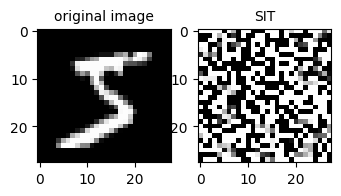

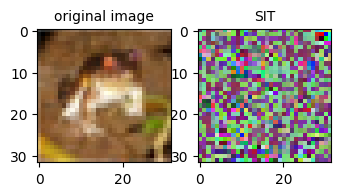

In [86]:
for img, label in itertools.islice(iter(mnist_train), 1):
    img = img.astype(np.uint8)
    show(img,imgsize=(28,28,1))
    
for img, label in itertools.islice(iter(cifar10_train), 1):
    img = img.astype(np.uint8)
    show(img,imgsize=(32,32,3))